In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import sys, os, csv, datetime
from typing import Dict
parent_directory = os.path.split(os.getcwd())[0]
src_directory = os.path.join(parent_directory, 'src')
data_directory = os.path.join('/scratch/groups/gracegao', 'Google_GNSS_data')
ephemeris_data_directory = os.path.join(data_directory, 'ephemeris')
sys.path.insert(0, src_directory)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import hydra
from omegaconf import DictConfig, OmegaConf

import xarray as xr

/home/groups/gracegao/conda_envs/deep_gnss/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [3]:
import gnss_lib.coordinates as coord
import gnss_lib.sim_gnss as sg 
import gnss_lib.read_nmea as nmea
import gnss_lib.utils as utils 
import gnss_lib.solve_pos as solve_pos

from gnss_lib.constants import gpsconsts
from gnss_lib.coordinates import ecef2geodetic

from utils import *

from dataset.sim_dataset_seq import Sim_GNSS_Dataset_Seq
from correction_network.set_transformer_reduction import *
from correction_network.architectures import *

In [4]:
from tqdm.notebook import tqdm

In [108]:
data_config = {
    "root": os.path.join(data_directory, "simulated_matlab_clockcorr_half_small_rebatched_bias_ctx"),
    "measurement_dir" : "gnss_data",
    # "initialization_dir" : "initialization_data",
    # "info_path": "data_info.csv",
    "max_open_files": 10000,
    "guess_range": [100]*4 + [1e-5]*4,
    "history": 5,
    "seed": 0
        #TODO: Add all required parameters to the data_config file. Maybe set up data_config in train_conf.yaml?
    }

In [109]:
dataset = Sim_GNSS_Dataset_Seq(data_config, verbose=True)

Creating coordinates...


100%|██████████| 1781/1781 [00:00<00:00, 212277.79it/s]


Saving filenames and indexing...


100%|██████████| 1781/1781 [00:00<00:00, 1840.05it/s]


In [110]:
train_set, val_set = torch.utils.data.random_split(dataset, [int(0.1*len(dataset)), len(dataset) - int(0.1*len(dataset))])
    
print("Creating train and val dataloaders")
dataloader = DataLoader(train_set, batch_size=8,
                        shuffle=True, num_workers=0, collate_fn=collate_feat_sequential)
val_loader = DataLoader(val_set, batch_size=1, 
                        shuffle=False, num_workers=0, collate_fn=collate_feat_sequential)

Creating train and val dataloaders


In [122]:
base_save_path = os.path.join(data_directory, "weights")
save_path = os.path.join(base_save_path, "9_12_22_1440_fcembed_snap_ctx2")
# load_path = os.path.join(base_save_path, "8_10_22_1750_hdlsembed_snap")

embedding = FullyConnectedNetwork(dim_input=4, max_sats=10, dim_output=16, batch_first=True)
# embedding = LearnedWLSEmbeddings(output_dim=16, batch_first=True, output_residual=False)
# embedding = SetTransformerPointOutput(4, 1, 16, batch_first=True)

# net = LearnedEmbeddingsRNN(embedding, batch_first=True, time_last=True)
# net = LearnedEmbeddingsTransformer(embedding, batch_first=True, time_last=True, d_model=6, nhead=1, num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=16)
net = LearnedEmbeddingsSnapshot(embedding, batch_first=True, time_last=True)
net.cuda()

LearnedEmbeddingsSnapshot(
  (embedding): FullyConnectedNetwork(
    (feat_in): Sequential(
      (0): Linear(in_features=50, out_features=64, bias=True)
      (1): PReLU(num_parameters=1)
    )
    (enc): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): PReLU(num_parameters=1)
    )
    (feat_out): Sequential(
      (0): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [123]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net.embedding)   # FC - 20949, WLS - 2021, SetTF - 11440

20949

In [124]:
optimizer = torch.optim.Adam(net.parameters(), 3e-4)
loss_func = torch.nn.MSELoss(reduction='none')
count = 0
loss_arr = []

In [125]:
# checkpoint = torch.load(load_path)
# net.embedding.load_state_dict(checkpoint['embedding'])
# # net.lstm.load_state_dict(checkpoint['lstm'])
# # net.fc.load_state_dict(checkpoint['fc'])
# # net.fc_dxt.load_state_dict(checkpoint['fc_dxt'])
# net.load_state_dict(checkpoint['net'])
# # optimizer.load_state_dict(checkpoint['optimizer'])

In [126]:
# _sample_batched['sv_features'].shape, _sample_batched['true_corrections'].shape, _sample_batched['pose_features'].shape, _sample_batched['mask_times'].shape, pad_mask.shape, pred_correction.shape

In [127]:
for epoch in tqdm(range(10), desc='epoch'):
    # TRAIN Phase
    net.train()
    for i, sample_batched in enumerate(tqdm(dataloader, leave=False)):
        _sample_batched, pad_mask = sample_batched

#         x = _sample_batched['sv_features'][:, :, 0, :].float().cuda()
#         y = _sample_batched['true_corrections'][:, :, 0].float().cuda()

        x = _sample_batched['sv_features'].float().cuda()    # (B, SVs, timesteps, feat_dim)
        y = _sample_batched['true_corrections'].float().cuda()       # (B, output_dim, timesteps)
        dxt_feat = _sample_batched['pose_features'].float().cuda()    # (B, guess_pose_feat_dim, timesteps)
        mask_times = _sample_batched['mask_times'].cuda()    # (B, timesteps)
        
#         pad_mask = pad_mask[:, :, 0].cuda()
        pad_mask = pad_mask.cuda()   # (B, SVs, timesteps)
        pred_correction = net(x, dxt_feat, pad_mask=pad_mask, mask_times=mask_times)    # (B, output_dim, timesteps)
        
        loss = loss_func(pred_correction, y)
        loss = (loss * torch.unsqueeze(mask_times.float(), 1)).sum()
        loss_arr.append(loss.item())

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    # TEST Phase
    net.eval()

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

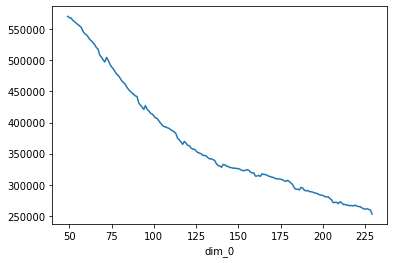

In [128]:
loss_xr = xr.DataArray(loss_arr)
loss_xr.rolling(dim_0=50).mean().plot()

In [129]:
net.eval()
T = data_config["history"]+1
out_pred = [[] for _ in range(T)]
out_true = [[] for _ in range(T)]


for i, sample_batched in enumerate(tqdm(val_loader, desc='val')):
    _sample_batched, pad_mask = sample_batched

    x = _sample_batched['sv_features'].float().cuda()
    y = _sample_batched['true_corrections'].float().cuda()
    dxt_feat = _sample_batched['pose_features'].float().cuda()
    mask_times = _sample_batched['mask_times'].cuda()

    pad_mask = pad_mask.cuda()
    pred_correction = net(x, dxt_feat, pad_mask=pad_mask, mask_times=mask_times)

    pred_correction = pred_correction.detach().cpu()
    y = y.detach().cpu()
    for t in range(T):
        if mask_times[0, t]:
            out_pred[t].append(pred_correction[0, :, t])
            out_true[t].append(y[0, :, t])

val:   0%|          | 0/1603 [00:00<?, ?it/s]

In [130]:
out_pred = [torch.stack(_out_pred) for _out_pred in out_pred]
out_true = [torch.stack(_out_true) for _out_true in out_true]
sorted_idx = [[] for _ in range(T)]
for t in range(T):
    for i in range(4):
        sorted_idx[t].append(torch.argsort(out_true[t][:, i]))

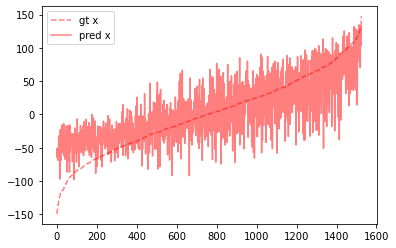

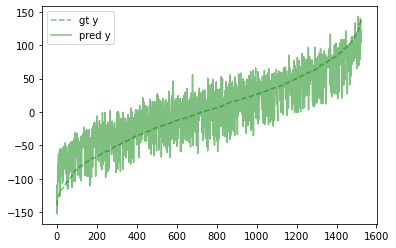

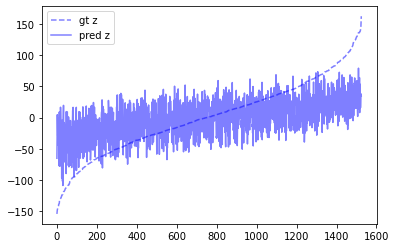

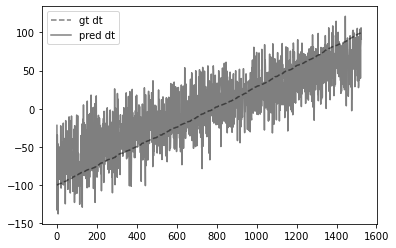

In [131]:
t = 5

plt.figure()
plt.plot(out_true[t][sorted_idx[t][0], 0], 'r--', label='gt x', alpha=0.5)
plt.plot(out_pred[t][sorted_idx[t][0], 0], 'r', label='pred x', alpha=0.5)
plt.legend()

plt.figure()
plt.plot(out_true[t][sorted_idx[t][1], 1], 'g--', label='gt y', alpha=0.5)
plt.plot(out_pred[t][sorted_idx[t][1], 1], 'g', label='pred y', alpha=0.5)
plt.legend()

plt.figure()
plt.plot(out_true[t][sorted_idx[t][2], 2], 'b--', label='gt z', alpha=0.5)
plt.plot(out_pred[t][sorted_idx[t][2], 2], 'b', label='pred z', alpha=0.5)
plt.legend()

plt.figure()
plt.plot(out_true[t][sorted_idx[t][3], 3], 'k--', label='gt dt', alpha=0.5)
plt.plot(out_pred[t][sorted_idx[t][3], 3], 'k', label='pred dt', alpha=0.5)
plt.legend()

In [93]:
hist_diff = [np.abs((out_true[t]-out_pred[t]).numpy()) for t in range(T)]

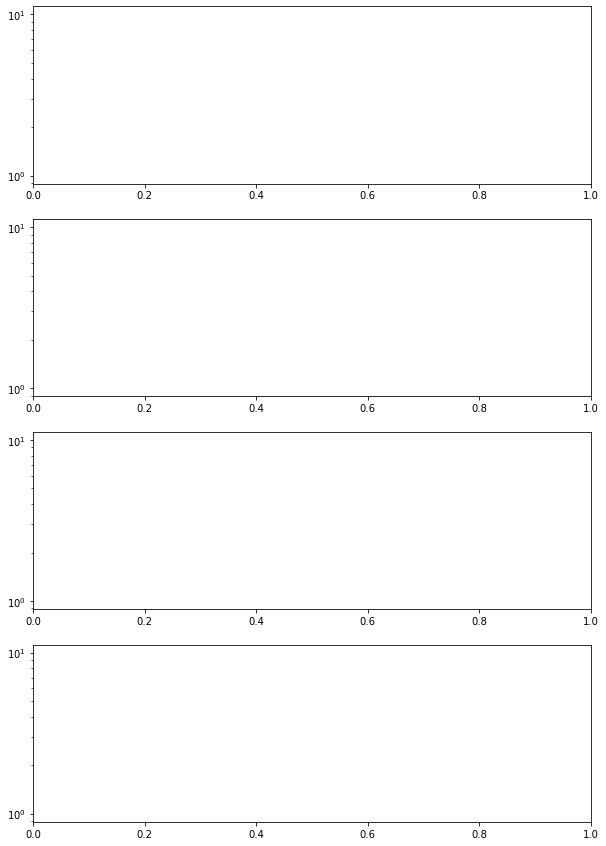

In [29]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10, 15))
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')

In [30]:
t=0

# hist_diff = hist_diff_1
# name = "Fully Connected"
# color = plt.cm.hsv(0.9)

# hist_diff = hist_diff_2
# name = "High-dim LS"
# color = plt.cm.hsv(0)

# hist_diff = hist_diff_3
# name = "Set Transformer"
# color = plt.cm.hsv(0.2)

# hist_diff = hist_diff_4
# t=5
# name = "High-dim LS w/ LSTM t+"+str(t)
# color = plt.cm.Blues((t+1)/6)

ax1.hist(hist_diff[t][:, 0], density=True, cumulative=True,
         histtype='step', bins=1000, alpha=0.5, label=name+" x", color=color)
ax1.legend()

ax2.hist(hist_diff[t][:, 1], density=True, cumulative=True,
         histtype='step', bins=1000, alpha=0.5, label=name+" y", color=color)
ax2.legend()

ax3.hist(hist_diff[t][:, 2], density=True, cumulative=True,
         histtype='step', bins=1000, alpha=0.5, label=name+" z", color=color)
ax3.legend()

ax4.hist(hist_diff[t][:, 3], density=True, cumulative=True,
         histtype='step', bins=1000, alpha=0.5, label=name+" cdt", color=color)
ax4.legend()

NameError: name 'hist_diff_4' is not defined

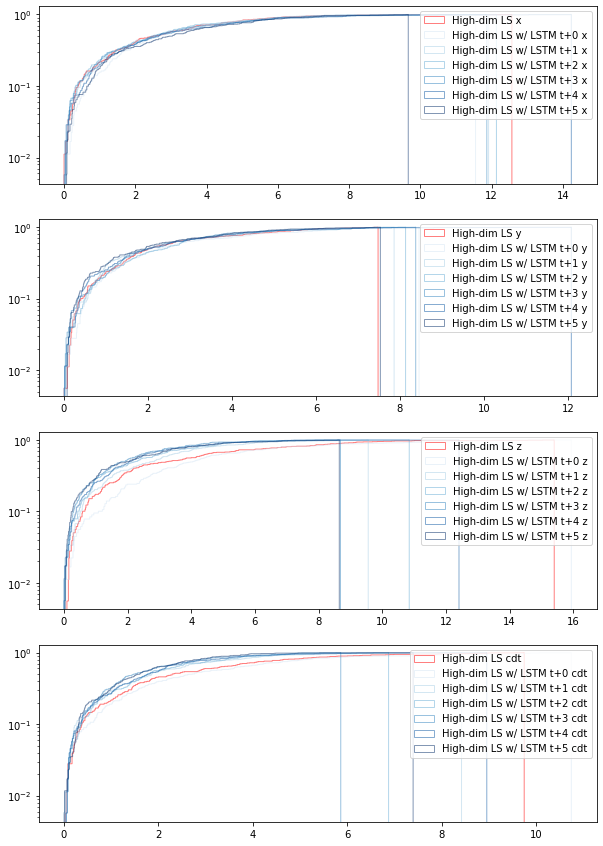

In [486]:
fig

In [452]:
# hist_diff_1 = hist_diff   # FC snapshot
# hist_diff_2 = hist_diff   # HDLS snapshot
# hist_diff_3 = hist_diff   # SetTF snapshot
# hist_diff_4 = hist_diff   # HDLS-LSTM

In [132]:
checkpoint = {
    'embedding': net.embedding.state_dict(),
#     'lstm': net.lstm.state_dict(),
#     'transformer': net.transformer.state_dict(),
#     'fc': net.fc.state_dict(),
#     'fc_dxt': net.fc_dxt.state_dict(),
    'net': net.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss': loss_xr,
}

torch.save(checkpoint, save_path)